## **CS3244 Project - Models**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV

In [ ]:
# General function for running any model
def run(X_train, y_train, X_test, y_test, model):
  model.fit(X_train, y_train)
  X_train_predict = model.predict(X_train)
  X_test_predict = model.predict(X_test)
  train_score_roc = roc_auc_score(y_train, X_train_predict)
  test_score_roc = roc_auc_score(y_test, X_test_predict)
  train_score = precision_recall_fscore_support(y_train, X_train_predict, average='micro')
  test_score = precision_recall_fscore_support(y_test, X_test_predict, average='micro')
  print(f"Training performance (ROC-AUC): {train_score_roc}")
  print(f"Test performance (ROC-AUC): {test_score_roc}")
  print(f"Training performance (Precision - Recall - F1): {train_score}")
  print(f"Test performance (Precision - Recall - F1): {test_score}")

In [ ]:
# Display best hyperparameters for a given model
def tune(X_train, y_train, X_test, y_test, model, hyperparameters):
  clf = GridSearchCV(model, hyperparameters)
  clf.fit(X_train, y_train)
  print("Best hyperparameters: " + str(clf.best_params_))

  # Run the model with the best params
  model.set_params(**clf.best_params_)
  run(X_train, y_train, X_test, y_test, model)

## Import Data

In [ ]:
# Run this only when you are using Google Colab
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download danofer/sarcasm
! unzip sarcasm
! kaggle datasets download chenyiyang/reddit-sarcasm-extracted-features-dataset
! unzip reddit-sarcasm-extracted-features-dataset

In [ ]:
# Read data
df = pd.read_csv('train-balanced-sarcasm.csv')
df['comment'].replace('', np.nan, inplace=True)
df.dropna(subset=['comment'], inplace=True)
X, y = df['comment'].values, df['label'].values

# Split into train (size 808618) and test (size 202155)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Generate Input Vectors

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def to_count(X_train, X_test):
  vectorizer = CountVectorizer()
  return vectorizer.fit_transform(X_train), vectorizer.transform(X_test)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif

MIN_DF = 2
TOP_K = 1000000
BEST_NGRAM_RANGE = (1, 3)

def to_tfidf(X_train, X_test, ngram_range):
  vectorizer = TfidfVectorizer(ngram_range=ngram_range, min_df=MIN_DF, 
    dtype=np.float64, strip_accents='unicode', decode_error='replace')
  X_train_tfidf = vectorizer.fit_transform(X_train)
  X_test_tfidf = vectorizer.transform(X_test)

  # Set a limit on the number of features in a vector
  selector = SelectKBest(f_classif, k=min(TOP_K, X_train_tfidf.shape[1]))
  selector.fit(X_train_tfidf, y_train)
  X_train_tfidf = selector.transform(X_train_tfidf).astype('float32')
  X_test_tfidf = selector.transform(X_test_tfidf).astype('float32')
  return X_train_tfidf, X_test_tfidf

In [ ]:
# vocab_size = 159401
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

def to_keras_embed(X_train, X_test):
  tokenizer = Tokenizer(num_words=100000)
  tokenizer.fit_on_texts(X_train)
  X_train_embed = tokenizer.texts_to_sequences(X_train)
  X_test_embed = tokenizer.texts_to_sequences(X_test)
  vocab_size = len(tokenizer.word_index) + 1

  # Pad with zeros so each embedding vector is equal length
  X_train_embed = pad_sequences(X_train_embed, padding='post', maxlen=200)
  X_test_embed = pad_sequences(X_test_embed, padding='post', maxlen=200)
  return X_train_embed, X_test_embed

In [ ]:
import nltk
nltk.download('punkt')
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

def to_dtv_embed(X_train, X_test):
  # Implemented based on https://medium.com/@mishra.thedeepak/doc2vec-simple-implementation-example-df2afbbfbad5
  tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(X_train)]
  model = Doc2Vec(size=250, alpha=0.025, min_alpha=0.00025, min_count=1, dm=1)
  model.build_vocab(tagged_data)
  model.train(tagged_data, total_examples=model.corpus_count, epochs=model.iter)
  model.alpha -= 0.0002
  model.min_alpha = model.alpha
  X_train_dtv = [model.infer_vector(word_tokenize(comment.lower())) for comment in X_train]
  X_test_dtv = [model.infer_vector(word_tokenize(comment.lower())) for comment in X_test]
  return X_train_dtv, X_test_dtv

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# X_train_counts, X_test_counts = to_count(X_train, X_test)
# X_train_tfidf, X_test_tfidf = to_tfidf(X_train, X_test, BEST_NGRAM_RANGE)
# X_train_keras, X_test_keras = to_keras_embed(X_train, X_test)
X_train_features, X_test_features = np.genfromtxt("X-train-v1.0.csv", delimiter=','), np.genfromtxt("X-test-v1.0.csv", delimiter=',')
# X_train_dtv, X_test_dtv = to_dtv_embed(X_train, X_test)

In [ ]:
#there is no weight assigned for classification yet 
from sklearn.preprocessing import StandardScaler
import scipy as sp

def combine_manual(X_train, X_test): #where X_train and X_test are X_train_tdidf/embed/etc
  X_test_combined, X_train_combined = sp.sparse.hstack((X_test_features,X_test)).tocsr(), sp.sparse.hstack((X_train_features,X_train)).tocsr()
  X_train_features_noneg, X_test_features_noneg = X_train_features[:,0:13], X_test_features[:,0:13]
  X_train_combined_13, X_test_combined_13 = np.abs(sp.sparse.hstack((X_train_features_noneg, X_train)).tocsr()), np.abs(sp.sparse.hstack((X_test_features_noneg, X_test)).tocsr())
  X_train_combined_abs, X_test_combined_abs = np.abs(X_train_combined), np.abs(X_test_combined)
  return X_train_combined, X_test_combined, X_train_combined_13, X_test_combined_13, X_train_combined_abs, X_test_combined_abs

#for SVM kept getting this warning so I used StandardScalar for now
#ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler. % self.max_iter, ConvergenceWarning)
#not sure if need to create 2 separate scalars for test and train

def standard_scaled(X_train):
  scaler = StandardScaler(with_mean=False)
  scaler.fit(X_train)
  X_train_scaled = scaler.transform(X_train)
  return X_train_scaled, X_test_scaled

#Note NB can't have negative values, can use X_train_combined_13 without emot and sentiment for a total of 13 manual features or X_train_combined_abs for absolute value
#for TFIDF + 15 manually extracted features ; can just change the dataset to whichever type if need to
X_train_combined, X_test_combined, X_train_combined_13, X_test_combined_13, X_train_combined_abs, X_test_combined_abs = combine_manual(X_train_tfidf, X_test_tfidf)

## Finding optimal TF-IDF vector hyperparameters

To find the best n-gram range `ngram_range`, we will tune this hyperparameter using a Naive Bayes model as it is the fastest model to run. We have found that the best n-gram range is **(1, 3)**.

In [ ]:
from sklearn.naive_bayes import MultinomialNB

def get_best_ngram_range(X_train, y_train, X_test, y_test):
    from itertools import combinations
    ranges = list(combinations(range(1, 7), 2))
    ranges = [(1, 1)] + ranges
    for r in ranges:
        print(str(r) + ":")
        X_train_tfidf, X_test_tfidf = to_tfidf(X_train, X_test, r)
        run(MultinomialNB(alpha=0.01, fit_prior=False), X_train_tfidf, y_train, X_test_tfidf, y_test)

# get_best_ngram_range(X_train, y_train, X_test, y_test)

## **Baseline Models - Result Summary**

| Model | Hyperparameters | Input | Training ROC-AUC | Test ROC-AUC |
| :-: | :-: | :-: | :-: | :-: |
| Naive Bayes | Default | TF-IDF (`ngram_range=(1,1)`) | 0.723 | 0.669 |
| Naive Bayes | `alpha=1.0, fit_prior=False` | TF-IDF (`ngram_range=(1,1)`) | 0.725 | 0.674 |
| Naive Bayes | `alpha=0.01, fit_prior=False` | TF-IDF (`ngram_range=(1,3), top_k=20000`) | 0.719 | 0.705 |
| Naive Bayes | `alpha=0.3, fit_prior=False` | TF-IDF (`ngram_range=(1,3), top_k=1000000`) + 13 Manual Features | 0.830 | 0.712 |
| Naive Bayes | `alpha=0.3, fit_prior=False` | TF-IDF (`ngram_range=(1,3), top_k=1000000`) + 15 Manual Features | 0.829 | 0.711 |
| Naive Bayes | `alpha=0.8, fit_prior=False` | TF-IDF (`ngram_range=(1,3), top_k=1000000`) | 0.827 | 0.717 |
| Logistic Regression | Default | Manual Features | 0.573 | 0.572 |
| Logistic Regression | Default | DocToVec (`size=20, max_epoch=1`) | 0.598 | 0.596 |
| Logistic Regression | Default | DocToVec (`size=30, max_epoch=1`) | 0.606 | 0.606 |
| Logistic Regression | Default | DocToVec (`size=100, max_epoch=1`) | 0.620 | 0.620 |
| Logistic Regression | Default | DocToVec (`size=250, max_epoch=1`) | 0.633 | 0.636 |
| Logistic Regression | Default | DocToVec (`size=500, max_epoch=1`) | 0.634 | 0.635 |
| Logistic Regression | Default | Keras Embeddings (`size=100`) | 0.741 | 0.692 |
| Logistic Regression | Default | TF-IDF (`ngram_range=(1,3), top_k=20000`) | 0.726 | 0.715 |
| Logistic Regression | `C=10` | TF-IDF (`ngram_range=(1,3), top_k=20000`) | 0.733 | 0.716 |
| Logistic Regression | `C=1` | Manual Features + TF-IDF (`ngram_range=(1,3), top_k=100`)  | 0.648 | 0.649 |
| Logistic Regression | `C=1000` | Manual Features + TF-IDF (`ngram_range=(1,3), top_k=1000`)  | 0.686 | 0.685 |
| Support Vector Machine | Default | Manual Features | - | 0.590 |
| Support Vector Machine | `max_iter=20000` | TF-IDF (`ngram_range=(1,3), top_k=50000`)  | 0.487 | 0.484 |
| Support Vector Machine | `max_iter=20000` | Manual Features + TF-IDF (`ngram_range=(1,3), top_k=50000`)  | 0.517 | 0.518 |
| SVM + LR + NB | Stacked using LR | Manual Features + TF-IDF (`ngram_range=(1,3), top_k=50000`)  | 0.744 | 0.724 |

## Naive Bayes (NB)

In [ ]:
tune(X_train_combined_13, y_train, X_test_combined_13, y_test, MultinomialNB(), { 
    'alpha': [0.3], 
    'fit_prior': [False]})
tune(X_train_combined_abs, y_train, X_test_combined_abs, y_test, MultinomialNB(), {
    'alpha': [0.3], 
    'fit_prior': [False]})
tune(X_train_tfidf, y_train, X_test_tfidf, y_test, MultinomialNB(), {
    'alpha': [0.8], 
    'fit_prior': [False]})

## Logistic Regression (LR)

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_params = {'C': [10]}
tune(X_train_tfidf, y_train, X_test_tfidf, y_test, LogisticRegression(max_iter=10000), lr_params)
# tune(X_train_features, y_train, X_test_features, y_test, LogisticRegression(max_iter=10000), lr_params)
# run(X_train_dtv, y_train, X_test_dtv, y_test, LogisticRegression(max_iter=10000))

Best hyperparameters: {'C': 10}
Training performance (ROC-AUC): 0.9266169996635394
Test performance (ROC-AUC): 0.714090129796616
Training performance (Precision - Recall - F1): (0.9266155341582799, 0.9266155341582799, 0.9266155341582799, None)
Test performance (Precision - Recall - F1): (0.7141055130963865, 0.7141055130963865, 0.7141055130963864, None)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import rfecv

visualizer = rfecv(RandomForestClassifier(), X=X_train_features, y=y_train, cv=StratifiedKFold(5), scoring='f1_weighted')

## Support Vector Machine (SVM)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

svm_params = {'C': [0.01, 0.1, 1, 10], 
              'gamma': [1,0.1,0.01,0.001],
              'kernel': ['rbf', 'poly', 'sigmoid']}

# tune(X_train_tfidf, y_train, X_test_tfidf, y_test, SVC(), svm_params)
run(X_train_features, y_train, X_test_features, y_test, SVC(max_iter=20000))

## **Convolutional Neural Network (CNN)**

We implement a Convolutional Neural Network (CNN) model with reference to [this article](https://analyticsindiamag.com/guide-to-text-classification-using-textcnn/).

In [ ]:
# Create CNN model
from keras.models import Sequential
from keras import layers

| Hyperparameters | Training Performance | Test Performance |
| :-: | :-: | :-: |
| `epoch=1, vocab_size=30000` | 0.7257 | 0.7123 |
| `epoch=10, vocab_size=30000` | 0.8524 | 0.6922 |
| `epoch=1, vocab_size=100000, embedding_dim=200, maxlen=100` | 0.7233 | 0.7116 |
| `epoch=1, vocab_size=20000, embedding_dim=200, maxlen=200` | 0.7470 | 0.7264 |
| `epoch=1, vocab_size=200000, embedding_dim=200, maxlen=200` | 0.7507 | 0.7262 |
| `epoch=3, vocab_size=200000, embedding_dim=200, maxlen=200` | 0.8282 | 0.7213 |



In [ ]:
embedding_dim = 200
vocab_size = 159401
maxlen = 200
epoch_num = 1
textcnnmodel = Sequential()
textcnnmodel.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
textcnnmodel.add(layers.Conv1D(256, 5, activation='relu'))
textcnnmodel.add(layers.GlobalMaxPooling1D())
textcnnmodel.add(layers.Dense(10, activation='relu'))
textcnnmodel.add(layers.Dense(1, activation='sigmoid'))
textcnnmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
textcnnmodel.summary() 

 

In [ ]:
# Apply CNN model
textcnnmodel.fit(X_train_embed, y_train, epochs=epoch_num, verbose=False, validation_data=(X_test_embed, y_test), batch_size=10)
loss, accuracy = textcnnmodel.evaluate(X_train_embed, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = textcnnmodel.evaluate(X_test_embed, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

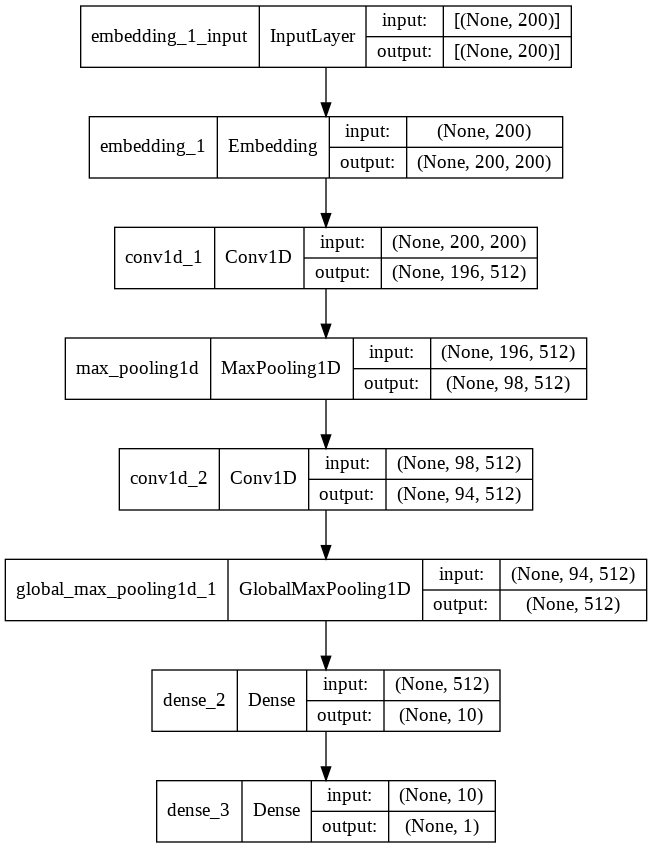

In [ ]:
# Generate diagram for CNN architecture
from keras.utils.vis_utils import plot_model
plot_model(textcnnmodel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)



# Evaluation

In [ ]:
# Get a CNN model
def get_cnn_model(epoch, vocab_size, embedding_dim, maxlen):
  textcnnmodel = Sequential()
  textcnnmodel.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
  textcnnmodel.add(layers.Conv1D(256, 5, activation='relu'))
  textcnnmodel.add(layers.GlobalMaxPooling1D())
  textcnnmodel.add(layers.Dense(10, activation='relu'))
  textcnnmodel.add(layers.Dense(1, activation='sigmoid'))
  textcnnmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  textcnnmodel.summary()
  return textcnnmodel

In [ ]:
model = get_cnn_model(1, 30000, 200, 100)
model.fit(X_train_embed, y_train, epochs=epoch_num, verbose=False, validation_data=(X_test_embed, y_test), batch_size=10)

In [ ]:
loss, accuracy = textcnnmodel.evaluate(X_train_embed, y_train, verbose=False)

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec, KeyedVectors

# creating corpus
corpus_text = 'n'.join(df['comment'])
data = []
# iterate through each sentence in the file
for i in sent_tokenize(corpus_text):
    temp = []
    # tokenize the sentence into words
    for j in word_tokenize(i):
        temp.append(j.lower())
    data.append(temp)

# Building word2vec model using Gensim
#CBOW
model1 = gensim.models.Word2Vec(data, min_count=1, size=100, window=5, sg=0)
#skip-gram
model2 = gensim.models.Word2Vec(data, min_count=1, size=100, window=5, sg=1)

Can consider using context + doc2vec as stated in article:
https://medium.com/@namanjain2050/using-deep-learning-to-identify-sarcasm-100a4a4ceaea

In [ ]:
# getting Google pretrained W2V
!pip install wget==3.2
from keras.models import load_model

import os
import wget
import gzip
import shutil

gn_vec_path = "GoogleNews-vectors-negative300.bin"
if not os.path.exists("GoogleNews-vectors-negative300.bin"):
    if not os.path.exists("../Ch2/GoogleNews-vectors-negative300.bin"):
        #Downloading the reqired model
        if not os.path.exists("../Ch2/GoogleNews-vectors-negative300.bin.gz"):
            if not os.path.exists("GoogleNews-vectors-negative300.bin.gz"):
                wget.download("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz")
            gn_vec_zip_path = "GoogleNews-vectors-negative300.bin.gz"
        else:
            gn_vec_zip_path = "../Ch2/GoogleNews-vectors-negative300.bin.gz"
        #Extracting the required model
        with gzip.open(gn_vec_zip_path, 'rb') as f_in:
            with open(gn_vec_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
    else:
        gn_vec_path = "../Ch2/" + gn_vec_path

print(f"Model at {gn_vec_path}")

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize

import gensim
from gensim.models import Word2Vec, KeyedVectors

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

train_bal = df.sample(frac=0.8)
remaining = df.drop(train_bal.index)
cv_bal = remaining.sample(frac=0.5)
test_bal = remaining.drop(cv_bal.index)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_bal['comment'].values)

encoded_comments_train = tokenizer.texts_to_sequences(train_bal['comment'])
encoded_comments_cv = tokenizer.texts_to_sequences(cv_bal['comment'])
encoded_comments_test = tokenizer.texts_to_sequences(test_bal['comment'])

vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

padded_comments_train = pad_sequences(encoded_comments_train, maxlen=200, padding='post')
padded_comments_cv = pad_sequences(encoded_comments_cv, maxlen=200, padding='post')
padded_comments_test = pad_sequences(encoded_comments_test, maxlen=200, padding='post')

y_train = train_bal['label'].values
y_cv = cv_bal['label'].values
y_test = test_bal['label'].values

y_train = to_categorical(y_train, num_classes=2)
y_cv = to_categorical(y_cv, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
159591


In [ ]:
#loading our W2V pre-trained vectors
w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# create a weight matrix for words in dictionary
embedding_matrix_w2v = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = w2v_model[word]
    except:
        embedding_vector = [0]*300
    
    if embedding_vector is not None:
        embedding_matrix_w2v[i] = embedding_vector

In [ ]:
from keras import Input, layers, Model, callbacks, optimizers
import tensorflow as tf
from keras import backend as K

# model definition - this model is purely based on content

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
        precision = precision_m(y_true, y_pred)
        recall = recall_m(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))

input_data = Input(shape=(200,), name='main_input')
embedding_layer = layers.Embedding(vocab_size, 300, weights=[embedding_matrix_w2v])(input_data)
conv_1 = layers.Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = layers.MaxPooling1D(pool_size=2)(conv_1)
conv_2 = layers.Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = layers.MaxPooling1D(pool_size=2)(conv_2)
flatten = layers.Flatten()(max_2)
dense = layers.Dense(100, activation='relu', name='fully_connected')(flatten)
out = layers.Dense(2, activation='softmax')(dense)

model_01 = Model(inputs=[input_data], outputs=[out])

print(model_01.summary())

#defining checkpoints
tensorboard = callbacks.TensorBoard(log_dir='model_01')

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = callbacks.ModelCheckpoint("model_01.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = callbacks.EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 2,
                            verbose=1)

#compiling model
c = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model_01.compile(optimizer=c, loss='categorical_crossentropy', metrics=['accuracy', f1_m, recall_m, precision_m])

#training
h1 = model_01.fit(padded_comments_train, y_train, 
               batch_size=256, 
               epochs=3, 
               verbose=1, callbacks=[tensorboard, checkpoint, earlystop, reduce_lr], 
               validation_data=(padded_comments_cv, y_cv))

In [ ]:
score_1 = model_01.evaluate(padded_comments_test, y_test)
print(score_1)
cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_01.predict(padded_comments_test), axis=1))
print(cnf_mat)

score_2 = model_01.evaluate(padded_comments_train, y_train)
print(score_2)

1036/6318 [===>..........................] - ETA: 2:29 - loss: 0.5543 - acc: 0.7143

In [ ]:
from lime import lime_text

def LIME_on_instance(model, X_train, y_train, X_test, y_test, id, raw_X_test, LIME_TOKENIZER):
  # Parameters
  NUM_FEATURES = 3

  # select observation
  instance = X_test[id]
  yhat_prob = model.predict(np.array([instance,]) , verbose=0)
  yhat_class = np.round(yhat_prob).astype(int)

  # check true value and predicted value
  print("True:", y_test[id], "--> Pred:", yhat_class[0][0], "| Prob:", round(np.max(yhat_prob),2))

  # takes a sentence, transform it into embeddings, 
  # then supply as input for the trained cnn model
  def sentence_predict(texts):
    _seq = LIME_TOKENIZER.texts_to_sequences(texts)
    _text_data = pad_sequences(_seq, padding = 'post', maxlen=200)
    predictions = model.predict(_text_data, verbose=0)

    predicts2d = []
    for pred in predictions:
      val = pred[0]
      predict2d = [val, 1-val]
      predicts2d.append(predict2d)
    return np.array(predicts2d)
  
  # show explanation
  classNames = ["sarcastic", "not sarcastc"]
  explainer = lime_text.LimeTextExplainer(class_names=
             classNames)
  explained = explainer.explain_instance(raw_X_test[id], 
             sentence_predict, num_features=6)
  explained.show_in_notebook(text=raw_X_test[id])

In [ ]:
# Show microscopic evaluation metrics
evaluate_model(model_01, padded_comments_train, y_train, padded_comments_test, y_test)

# Use LIME to explain on one instance
for i in range(50, 60):
  LIME_on_instance(model_01, X_train_embed, y_train, X_test_embed, y_test, i, X_test, LIME_TOKENIZER)

In [ ]:
from tqdm import tqdm_notebook
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import utils
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
        precision = precision_m(y_true, y_pred)
        recall = recall_m(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))

#step 1
def author_dict(data):
    
    author_dict = {}
    unique_auths = list(data['author'].unique())
    for author in tqdm_notebook(unique_auths):
        tmp = data[data['author'] == author]
        
        doc = ' '.join(tmp.comment)
        doc = doc.strip()
        author_dict[author] = doc
    
    return author_dict

train_author_dict = author_dict(train_bal)
cv_author_dict = author_dict(cv_bal)
test_author_dict = author_dict(test_bal)

In [ ]:
#step 2
tagged_docs = []
for key in train_author_dict:
    tokens = gensim.utils.simple_preprocess(train_author_dict[key])
    tagged_docs.append(gensim.models.doc2vec.TaggedDocument(tokens, key))
    
model = gensim.models.Doc2Vec(vector_size=100, window=10, min_count=5, workers=11, alpha=0.025, min_alpha=0.025)
model.build_vocab(tagged_docs)

for epoch in tqdm_notebook(range(50)):
    print("Epoch: ", epoch)
    model.alpha -= 0.002
    model.min_alpha = model.alpha
    model.train(tagged_docs, total_examples=model.corpus_count, epochs=model.iter)

In [ ]:
#step 3
author_vectors_dict = {}
for key in tqdm_notebook(train_author_dict):
    doc = train_author_dict[key]
    tokens = gensim.utils.simple_preprocess(doc)
    vector = model.infer_vector(tokens)
    author_vectors_dict[key] = vector

In [ ]:
#train user inputs
train_user_embs = [] 
for i, row in tqdm_notebook(train_bal.iterrows()):
    author = row['author']
    vec = author_vectors_dict[author]
    train_user_embs.append(vec)

#CV user inputs   
cv_user_embs = []  
for i, row in tqdm_notebook(cv_bal.iterrows()):
    author = row['author']
    if author in author_vectors_dict:
        vec = author_vectors_dict[author]
    else:
        vec = [0]*100
    cv_user_embs.append(vec)

#test user inputs
test_user_embs = []
for i, row in tqdm_notebook(test_bal.iterrows()):
    author = row['author']
    if author in author_vectors_dict:
        vec = author_vectors_dict[author]
    else:
        vec = [0]*100
    test_user_embs.append(vec)

In [ ]:
#model definition
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten)

#user input layer
input_user = Input(shape=(100,), name='user_input')
concat = concatenate([dense, input_user])

out = Dense(2, activation='softmax')(concat)

model_02 = Model(inputs=[input_data, input_user], outputs=[out])

print(model_02.summary())

#defining checkpoints
tensorboard = TensorBoard(log_dir='model_02')

reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = ModelCheckpoint("model_02.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 2,
                            verbose=1)
#input data                            
X_train = [padded_comments_train, np.array(train_user_embs)]
X_cv = [padded_comments_cv, np.array(cv_user_embs)]
X_test = [padded_comments_test, np.array(test_user_embs)]

#model compilation
c = optimizers.Adam(lr = 0.0001)
model_02.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_m, 'acc'])

#training model
h1 = model_02.fit(X_train, y_train, 
               batch_size=64, 
               epochs=20, 
               verbose=1, callbacks=[tensorboard, checkpoint, earlystop, reduce_lr], 
               validation_data=(X_cv, y_cv))

# Stacking

In [ ]:
from sklearn.datasets import make_classification
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix
def stacked_run(X_train, y_train, X_test, y_test):
  level0 = list()
  level0.append(('lr', LogisticRegression(max_iter=10000)))
  level0.append(('svm', SVC(max_iter=1000)))
  level0.append(('bayes', MultinomialNB()))
  # define meta learner model
  level1 = LogisticRegression()
  # define the stacking ensemble
  model = StackingClassifier(estimators=level0, final_estimator=level1)
  # fit the model on all available data
  # make a prediction for one example
  model.fit(X_train, y_train)
  X_train_predict = model.predict(X_train)
  X_test_predict = model.predict(X_test)
  train_score = roc_auc_score(y_train, X_train_predict)
  test_score = roc_auc_score(y_test, X_test_predict)
  tn, fp, fn, tp = confusion_matrix(y_test, X_test_predict).ravel()
  print((tn, fp, fn, tp))
  print(classification_report(y_test, X_test_predict))
  print(f"Training performance (ROC-AUC): {train_score_roc}")
  print(f"Test performance (ROC-AUC): {test_score_roc}")
  print(f"Training performance (Precision - Recall - F1): {train_score}")
  print(f"Test performance (Precision - Recall - F1): {test_score}")


stacked_run(X_train_combined_13,y_train,X_test_combined_13,y_test)